# CE7454 Project: Movie Rateing and Box-office Prediction

*Group 26: Li Jie, Shen Meng, Wang Ruihang*

Welcome to the our project! In this work, we are going to save the viewers and producers from the ocean of movies. Our job is to give a reliable prediction of a movies's rating and box-office before its theatrical release, aiming to offer useful information in an early stage. 

**In this project, we will:**
- Crawl and build our dataset from [IMDB](https://www.imdb.com)
- Clean and present the raw data for analysis
- Apply different models for movie rating and box-office prediction
- Propose our new architecture for further improvement
- Compare and analyze the results of each method

<table>

<img src="images/posters.png" style="width:800;height:300px;">

</table>

Run the following cell to load the packages and dependencies that are going to be useful for our project.

In [2]:
import os
import requests
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from torch.utils import data
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pickle
import seaborn as sns

%matplotlib inline

**Note**: We use the open source deep learning library [Pytorch](https://pytorch.org) to build our models

## 1 - Web Scraping for Dataset

IMDb provides an available dataset for personal and non-commercial use which includes some basic information of all kinds of videos, for example tv shows, shorts, dramas and etc.

The dataset is available here: https://datasets.imdbws.com.

### 1.1 Download Exsiting Dataset and Seperate the Movie Items

If you want to reproduce the code, please download and extract the following dataset, and put it into the `data` folder.

- https://datasets.imdbws.com/title.basics.tsv.gz
- https://datasets.imdbws.com/title.crew.tsv.gz
- https://datasets.imdbws.com/title.ratings.tsv.gz

First we have to filter the data we wanted, to seperate the movies data part, the movie data will be stored in `movie_list.csv`.

It may take few minutes.

In [2]:
file_basics = open('../data/title.basics.tsv','r')
file_movie_list = open('../data/movie_list.tsv','w')

# write header
line = file_basics.readline().split('\t')
file_movie_list.write('\t'.join([line[0],line[2],line[5],line[7],line[8]]))

# filter out all the movies with available Year Run_time
len_file_basics = 6218836
for line_num, line in enumerate(file_basics):
    line = line.split('\t')
    if line[1] == 'movie' and line[2]!='\\N' and line[5]!='\\N' and line[7]!='\\N':
        file_movie_list.write('\t'.join([line[0],line[2],line[5],line[7],line[8]]))
        print("progress:{:.3f}".format(line_num / len_file_basics * 100),end='\r',flush=True)
file_basics.close()
file_movie_list.close()

### 1.2 Overview of the Movie Data

After we filter out movies, let us see the distribution of movies on Years and Run time

In [8]:
import pandas as pd
file_movie_list = pd.read_csv('../data/movie_list.tsv', delimiter='\t')
file_movie_list.describe()

,startYear,runtimeMinutes
count,331500.000000,331500.000000
mean,1992.220624,88.334848
std,25.891248,146.000864
min,1894.000000,1.000000
25%,1976.000000,72.000000
50%,2003.000000,88.000000
75%,2013.000000,100.000000
max,2023.000000,59460.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11901a0d0>]],
      dtype=object)

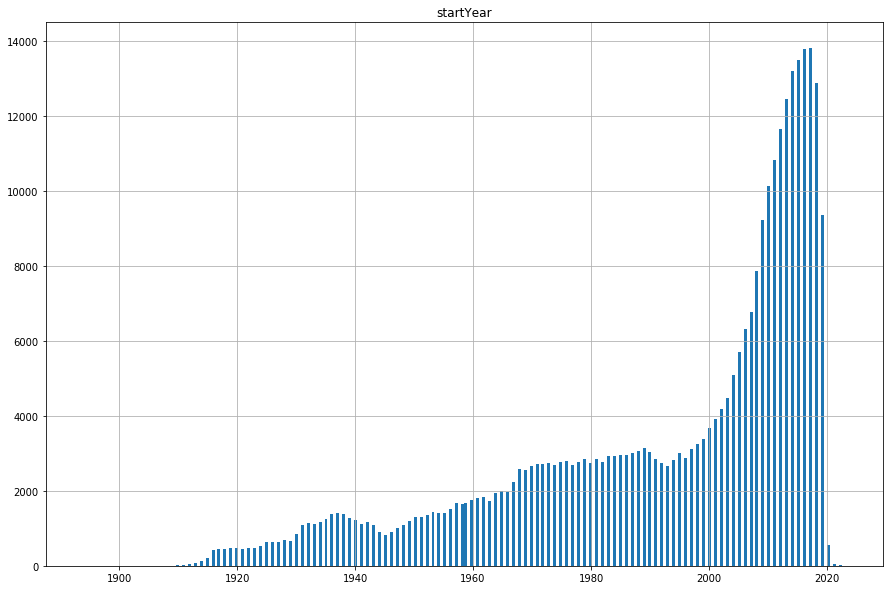

In [6]:
import matplotlib.pyplot as plt
file_movie_list.hist(column="startYear",figsize=(15,10),bins=256)

### 1.3 Select the Year Range of 2000 to 2018

According to the year distribution, we are going to keep the data which release years are between 2000 to 2018, and running times are between 60mins to 180 mins.

In [10]:
file_movie_list[(file_movie_list['startYear']>=2000) &
                (file_movie_list['startYear']<=2018) &
                (file_movie_list['runtimeMinutes']<=180) &
                (file_movie_list['runtimeMinutes']>=60)].to_csv(
    '../data/movie_2000_to_2018.tsv', sep='\t', index=None)

In [11]:
file_movie_list = pd.read_csv('../data/movie_2000_to_2018.tsv', delimiter='\t')
file_movie_list.describe()

,startYear,runtimeMinutes
count,141234.000000,141234.000000
mean,2011.183971,93.254698
std,4.993431,20.153978
min,2000.000000,60.000000
25%,2008.000000,80.000000
50%,2012.000000,90.000000
75%,2015.000000,102.000000
max,2018.000000,180.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122c3a5d0>]],
      dtype=object)

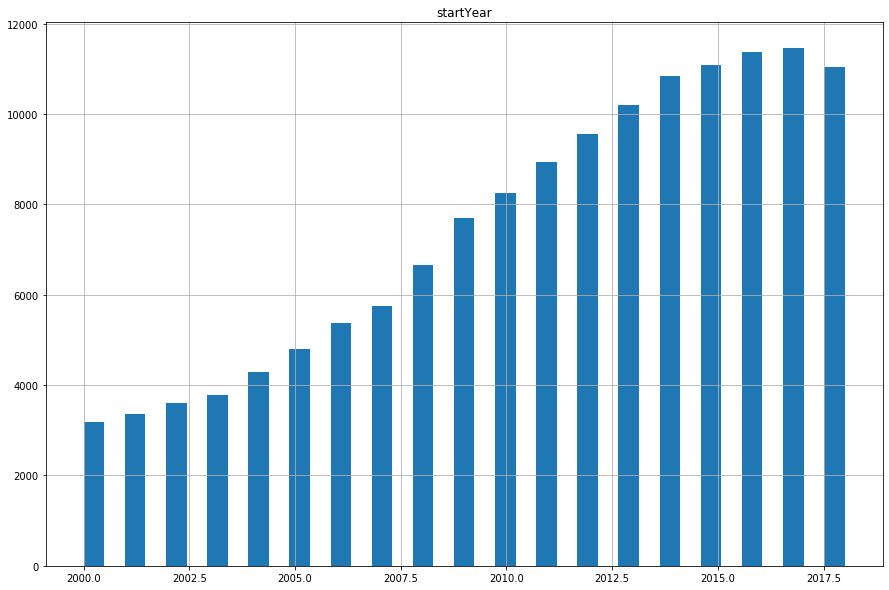

In [12]:
file_movie_list.hist(column="startYear",figsize=(15,10),bins=37)

### 1.4 Add Some Fields from Another Dataset

Then we add ratings, writers, directors and other fields to this data set and save it to `movie_2000_to_2018_part_1.tsv`.

In [13]:
file_crew = open('../data/title.crew.tsv','r')
file_movie_2000_to_2018 = open('../data/movie_2000_to_2018.tsv','r')
file_movie_2000_to_2018_part_1 = open('../data/movie_2000_to_2018_part_1.tsv','w')
_ = file_crew.readline()
_ = file_movie_2000_to_2018.readline()
for step, line in enumerate(file_movie_2000_to_2018):
    tt = line.split('\t')[0]
    tt_num = int(tt.split('tt')[1] + '0' * (10-len(tt)))
    while True:
        line_crew = file_crew.readline()
        line_crew = line_crew.split('\t')
        crew_tt = line_crew[0]
        if int(crew_tt.split('tt')[1]+ '0' * (10-len(crew_tt))) >= tt_num:
            break    
    if int(crew_tt.split('tt')[1]+ '0' * (10-len(crew_tt))) > tt_num:
        continue  
    directors = line_crew[1]
    writers = line_crew[2].split('\n')[0]
    new_line = [line.split('\n')[0], directors, writers]
    new_line = '\t'.join(new_line) + '\n'
    file_movie_2000_to_2018_part_1.write(new_line)
    

file_crew.close()
file_movie_2000_to_2018.close()
file_movie_2000_to_2018_part_1.close() 

Samely, we add rating informaton to the `part_1` dataset.

In [14]:
file_ratings = open('../data/title.ratings.tsv','r')
file_movie_2000_to_2018_part_1 = open('../data/movie_2000_to_2018_part_1.tsv','r')
file_movie_2000_to_2018_part_2 = open('../data/movie_2000_to_2018_part_2.tsv','w')
_ = file_ratings.readline()
_ = file_movie_2000_to_2018_part_1.readline()
_ = file_ratings.readline()
for step, line in enumerate(file_movie_2000_to_2018_part_1):
    tt = line.split('\t')[0]
    tt_num = int(tt.split('tt')[1] + '0' * (10-len(tt)))
    while True:
        line_ratings = file_ratings.readline()
        line_ratings = line_ratings.split('\t')
        ratings_tt = line_ratings[0]
        if int(ratings_tt.split('tt')[1]+ '0' * (10-len(ratings_tt))) >= tt_num:
            break    
    if int(ratings_tt.split('tt')[1]+ '0' * (10-len(ratings_tt))) > tt_num:
        continue  
    Rating = line_ratings[1]
    numVoters = line_ratings[2].split('\n')[0]
    new_line = [line.split('\n')[0], Rating, numVoters]
    new_line = '\t'.join(new_line) + '\n'
    file_movie_2000_to_2018_part_2.write(new_line)
    

file_ratings.close()
file_movie_2000_to_2018_part_1.close()
file_movie_2000_to_2018_part_2.close()

### 1.5 Run Crawler to Fetch More Related Information

Till now, we have the latest dataset `file_movie_2000_to_2018_part_2` including crew, rating information.

The next step is to run the crawler, and retrieve poster and other information such as budget, box office, storyline and stars from IMDb webpages.

```
cd project-folder/crawler

pip3 install -r requirements.txt

python spider.py
```

### 1.6 The Final Dataset: imdb.tsv

If you have trouble executing the previous code, it is ok, just start from here, `imdb.tsv` is an uncleaned dataset with all the fields.

## 2 - Preprocessing and Visualization

In this section, we investigate the impact of different variables on movie rating and box-office revenues. The data we crawled from Internet contains list of movie's information, such as budget, duration, genres, actors, directors, writers, story line, poster and its corresponding rating and box-office. Through preprocessing, the variables can be categorized as three types: *numerical data, vector data and image data*

- **Budget**: Budget is a numerical number that represents the financial investment in a movie
- **Duration**: Duration is a numerical number that defines the running time of a movie
- **Year**: Year is a numerical number that reveals the production time
- **Genres**: Movie genre is vector data with corresponding position set to one for a movie belongs to and others to zeros
- **Story line**: Story line is a word vector data that contains brief introduction of the movie
- **Poster**: Movie poster is a image data that contains potential information to exploit

### 2.1 Pre-processing for Box-office Prediction

### 2.2 Visualization

In [3]:
imdb = pd.read_csv('../data/imdb.tsv', sep='\t')
imdb['Ratio'] = imdb['Box_Office'] / (imdb['Budget'] + 1)
imdb['Ratio_Bool'] = imdb['Ratio'] >= 1
imdb = imdb.drop(imdb[(imdb['Ratio']>10) | (imdb['Budget'] < 10000) | (imdb['Ratio']<0.05)].index)
imdb

,Title,Budget,Box_Office,Star1,Star2,Star3,Star_num1,Star_num2,Star_num3,Name,Year,Run_Time,Genre,Director_num,Writer_num,Average_Rating,Num_Voters,Story_Line,Ratio,Ratio_Bool
1,tt0118589,22000000,5271666,Mariah Carey,Eric Benét,Max Beesley,nm0001014,nm0073160,nm0066586,Glitter,2001,104,"Drama,Music,Romance",nm0193554,"nm0921985,nm0486824",2.2,20922,"Billie Frank is a shy, young multiracial girl ...",0.239621,False
2,tt0120467,120000,15927,Brian O'Halloran,Bryan Johnson,Jerry Lewkowitz,nm0641168,nm0424682,nm0507915,Vulgar,2000,87,"Crime,Drama,Thriller",nm0424682,nm0424682,5.3,3840,"A loser with a crummy apartment, an odious mot...",0.132724,False
3,tt0120630,45000000,224834564,Mel Gibson,Julia Sawalha,Phil Daniels,nm0000154,nm0768018,nm0200057,Chicken Run,2000,84,"Adventure,Animation,Comedy","nm0661910,nm0520485","nm0520485,nm0661910,nm0456732,nm0123666,nm0640976",7.0,166546,Having been hopelessly repressed and facing ev...,4.996324,True
4,tt0120667,100000000,330120875,Ioan Gruffudd,Michael Chiklis,Chris Evans,nm0344435,nm0004821,nm0262635,Fantastic Four,2005,106,"Action,Adventure,Fantasy",nm1103162,"nm0004111,nm0289833,nm0498278,nm0456158",5.7,300227,"Reed Richards, a brilliant but timid and bankr...",3.301209,True
5,tt0120679,12000000,56298474,Salma Hayek,Alfred Molina,Geoffrey Rush,nm0000161,nm0000547,nm0001691,Frida,2002,123,"Biography,Drama,Romance",nm0853380,"nm0380419,nm0797397,nm1187860,nm0622695,nm0858482",7.4,75677,Frida chronicles the life Frida Kahlo shared u...,4.691539,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8272,tt9037222,1200000,2708622,Vladimir Zelenskiy,Anastasiya Korotkaya,Evgeniy Koshevoy,nm3305952,nm8701109,nm4915252,"Ya, Ty, Vin, Vona",2018,96,Comedy,"nm3305952,nm0230279","nm10366448,nm0230279,nm7928520,nm3424663,nm342...",5.3,237,"A married couple decides to divorce, but thing...",2.257183,True
8273,tt9095324,3207695,812524,Guy Berryman,Beyoncé,Jon Buckland,nm1363068,nm0461498,nm1363136,Coldplay: A Head Full of Dreams,2018,115,"Documentary,Music",nm1475971,\N,8.0,2064,A HEAD FULL OF DREAMS offers an in-depth and i...,0.253305,False
8274,tt9203168,1517700,904513,Horatiu Malaele,Iosif Pastina,Dana Dogaru,nm0538855,nm3844603,nm0230483,Moromete Family: On the Edge of Time,2018,110,Drama,nm0347720,"nm0347720,nm0695737",7.7,1186,A sequel to Romanian cinema's best-known famil...,0.595976,False
8275,tt9272138,397949,22337,Jianjun Ding,Bo Dong,Shuilin Long,nm10705955,nm10705956,nm10705957,Out of Crimes,2018,91,Crime,nm10255953,nm10255953,4.9,11,Miner Junpo's daughter is seriously ill and ne...,0.056130,False


In [4]:
imdb.describe()

,Budget,Box_Office,Year,Run_Time,Average_Rating,Num_Voters,Ratio
count,6.567000e+03,6.567000e+03,6567.000000,6567.000000,6567.000000,6.567000e+03,6567.000000
mean,2.331077e+07,5.699841e+07,2009.421349,105.492005,6.184316,5.698153e+04,1.650018
std,3.761012e+07,1.406144e+08,5.011153,17.941605,1.084342,1.256721e+05,1.896471
min,1.000000e+04,5.810000e+02,2000.000000,60.000000,1.100000,5.000000e+00,0.050021
25%,2.000000e+06,8.021520e+05,2006.000000,93.000000,5.600000,1.099000e+03,0.274666
50%,8.000000e+06,5.758522e+06,2009.000000,102.000000,6.300000,8.962000e+03,0.922471
75%,2.700000e+07,4.454230e+07,2014.000000,115.000000,6.900000,5.479400e+04,2.332574
max,3.210000e+08,2.048360e+09,2018.000000,180.000000,9.400000,2.111245e+06,9.985523


#### We can see that 48.104 percent of movies are profitable.

percentage of profitable movies: 48.104


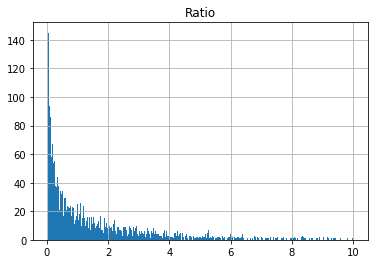

In [5]:
print("percentage of profitable movies: %0.3f" % float((imdb['Ratio']>1).sum() / len(imdb) * 100))
imdb.hist(column="Ratio",bins=1000)
plt.show()

### Most of the movies' rating are around 7

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1faf3310>]],
      dtype=object)

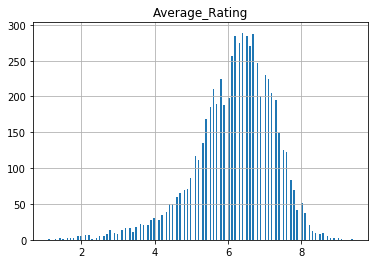

In [6]:
imdb.hist(column="Average_Rating",bins=200)

### Relation between Rating and whether Profitable

Profitalbe Movies' Average Rating is 6.352 which is slightly higher than unprofitable movies' average rating 6.029

Profitable Movies' Average Rating: 6.352
Unprofitable Movies' Average Rating: 6.029


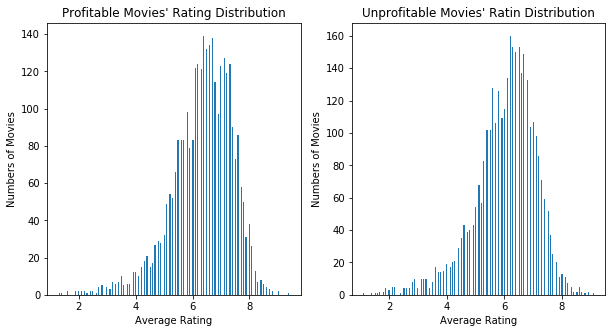

In [12]:
print("Profitable Movies' Average Rating: %.3f" % (imdb[imdb['Ratio']>1]['Average_Rating'].sum() / (imdb['Ratio']>1).sum()))
print("Unprofitable Movies' Average Rating: %.3f" % (imdb[imdb['Ratio']<=1]['Average_Rating'].sum() / (imdb['Ratio']<=1).sum()))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(imdb[imdb['Ratio']>1]['Average_Rating'].to_numpy(),bins=(200))
plt.xlabel("Average Rating")
plt.ylabel("Numbers of Movies")
plt.title("Profitable Movies' Rating Distribution")

plt.subplot(122)
plt.hist(imdb[imdb['Ratio']<1]['Average_Rating'].to_numpy(), bins = 200)
plt.xlabel("Average Rating")
plt.ylabel("Numbers of Movies")
plt.title("Unprofitable Movies' Ratin Distribution")
plt.show()


### Genre and Average Rating

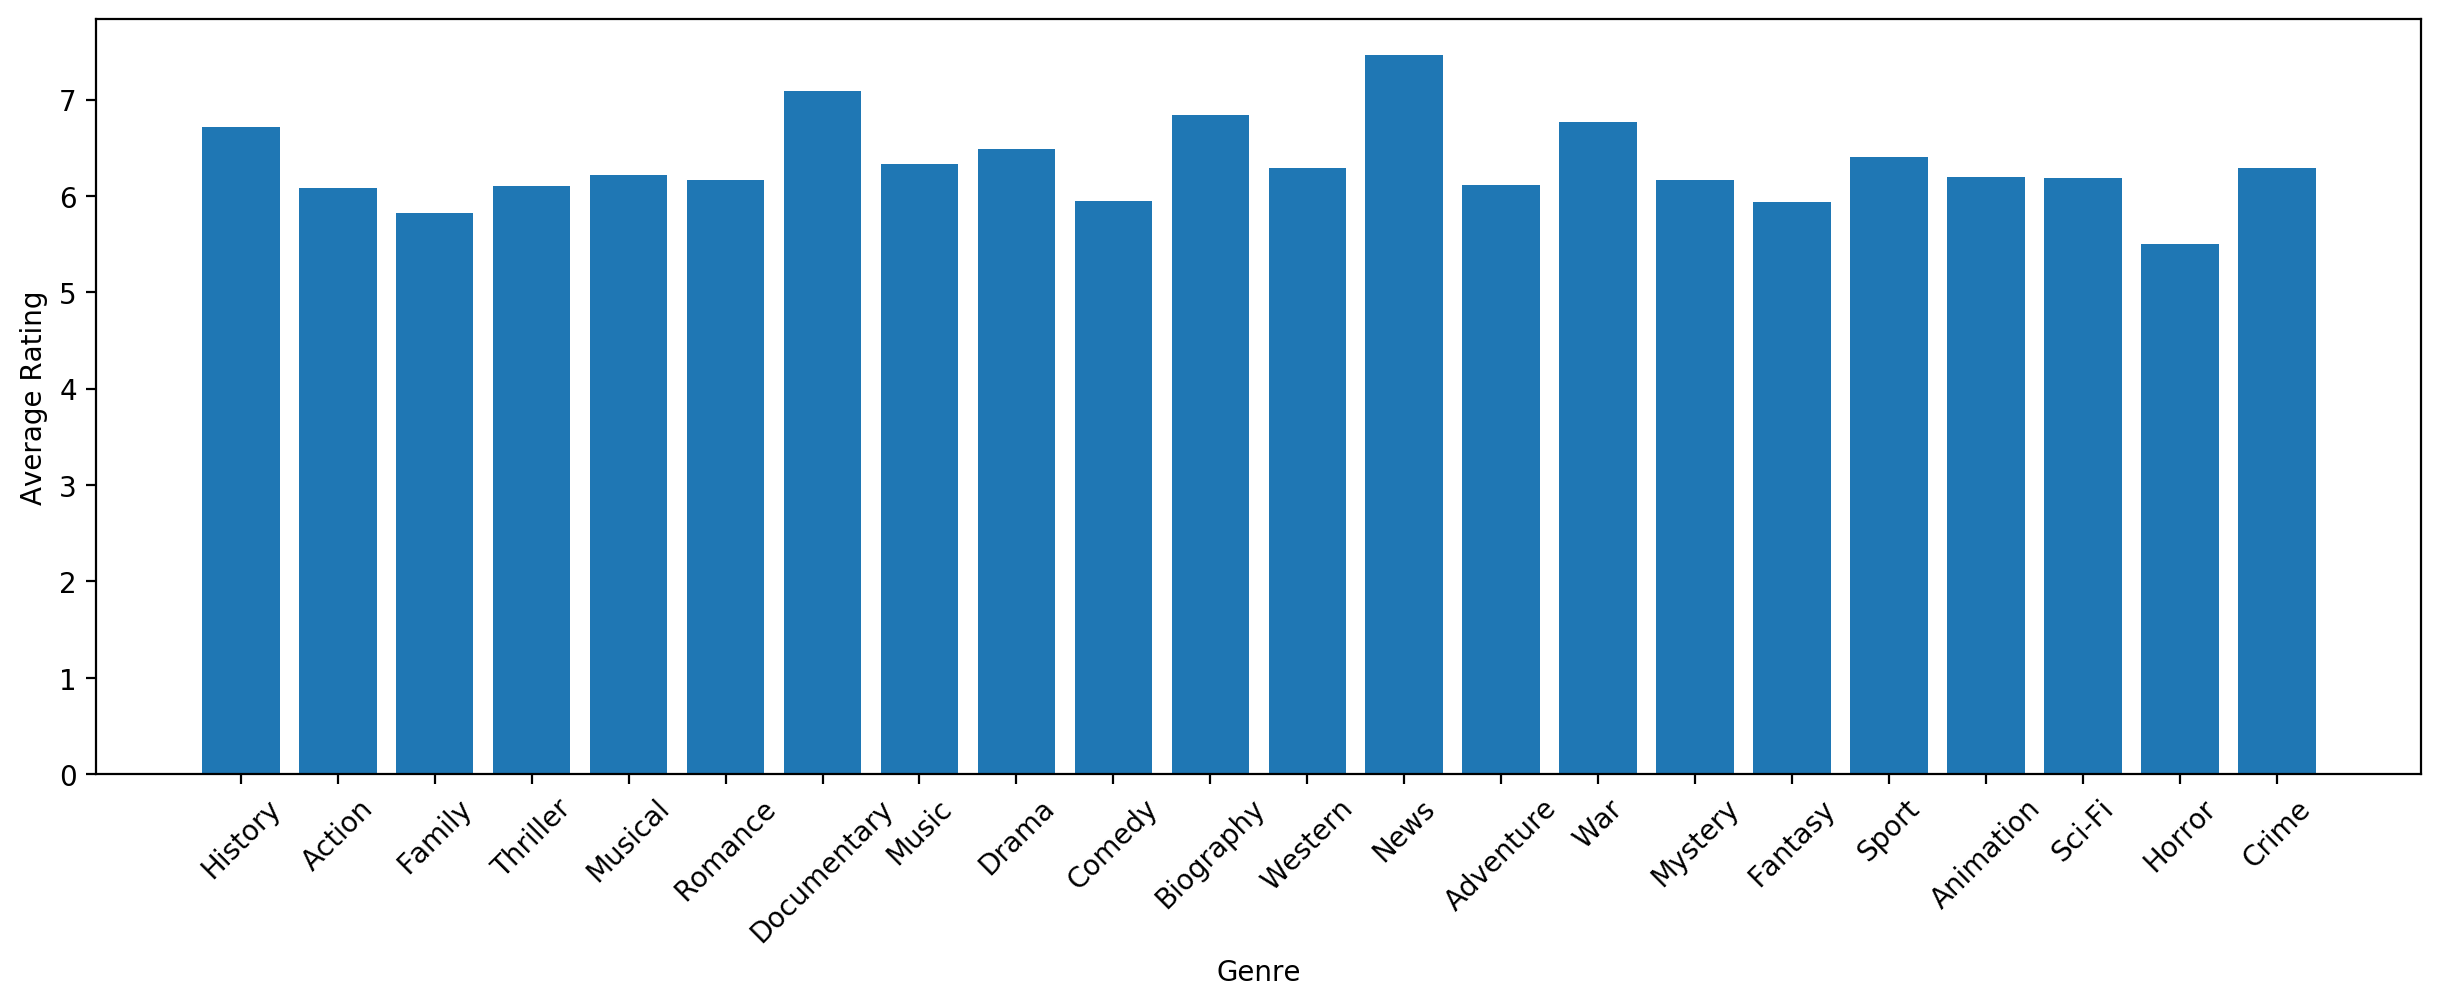

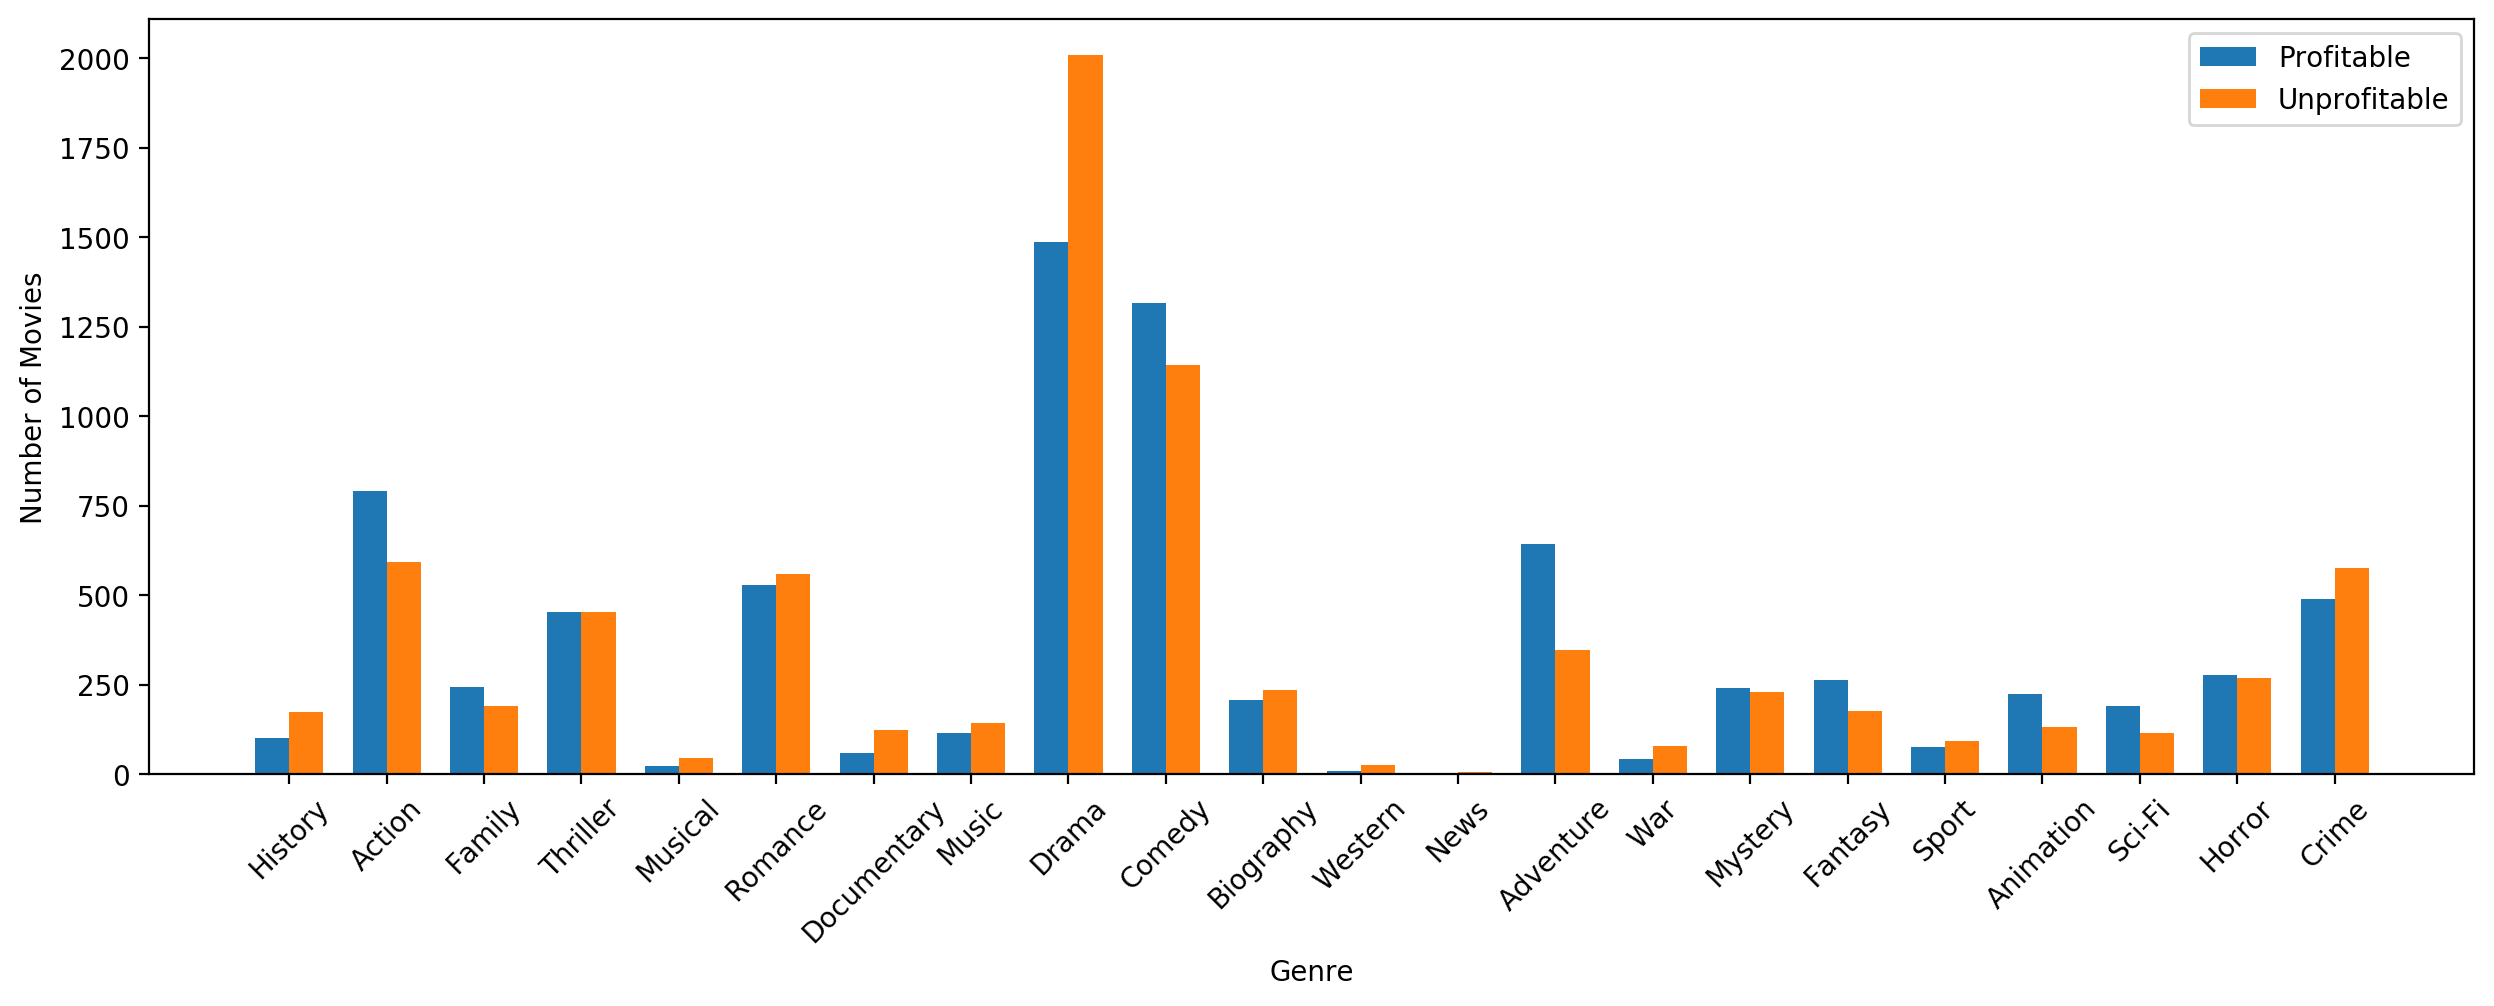

In [30]:
genre_set = set()
for row in imdb.iterrows():
    for each in row[1]['Genre'].split(','):
        if each != "\\N":
            genre_set.add(each)
genre_rating_group = {}

for each_genre in genre_set:
    genre_rating = imdb[imdb['Genre'].str.contains(each_genre)]['Average_Rating'].sum()
    genre_num = (imdb['Genre'].str.contains(each_genre)).sum()
    genre_rating_group[each_genre] = genre_rating / genre_num

plt.figure(dpi=200,figsize=(15,5))
plt.bar(range(len(genre_set)), [genre_rating_group.get(x) for x in genre_set])
plt.xticks(range(len(genre_set)), genre_set, rotation=45)
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.show()

genre_ratio_group = {}
for each_genre in genre_set:
    genre_ratio_positive = imdb[imdb['Genre'].str.contains(each_genre)]['Ratio_Bool'].sum()
    genre_num = (imdb['Genre'].str.contains(each_genre)).sum()
    genre_ratio_negative = genre_num - genre_ratio_positive
    genre_ratio_group[each_genre] = (genre_ratio_positive, genre_ratio_negative)

x = np.arange(len(genre_set))
width = 0.35
plt.figure(dpi=200,figsize=(15,5))
plt.bar(x - width/2, [genre_ratio_group.get(x)[0] for x in genre_set], width, label="Profitable")
plt.bar(x + width/2, [genre_ratio_group.get(x)[1] for x in genre_set], width, label="Unprofitable")
plt.xticks(range(len(genre_set)), genre_set, rotation=45)
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.legend()
plt.show()

### Year and Rating

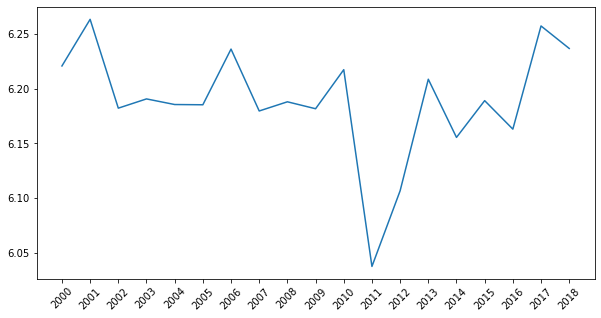

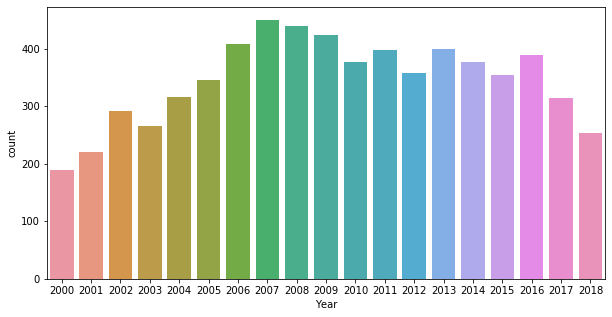

In [18]:
year_rating = []
for year in range(2000,2019):
    rating = imdb[imdb['Year'] == year]['Average_Rating'].sum() 
    movie_num = (imdb['Year'] == year).sum()
    rating /= movie_num
    year_rating.append(rating)

plt.figure(figsize=(10,5))
plt.plot(range(2000,2019), year_rating)
plt.xticks(list(range(2000,2019)), rotation=45)
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(x='Year',data=imdb)
plt.show()

### Run time and Rating

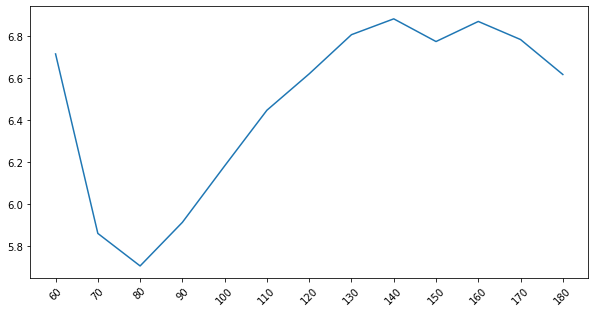

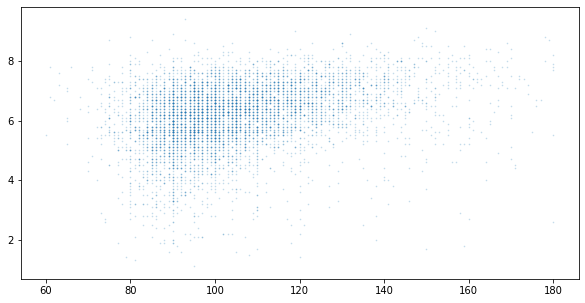

In [31]:
run_time_rating=[]
time_interval = 10
for run_time in range(60,181,time_interval):
    rating = imdb[(imdb['Run_Time'] >= run_time) & (imdb['Run_Time'] < run_time + time_interval)]['Average_Rating'].sum() 
    movie_num = ((imdb['Run_Time'] >= run_time) & (imdb['Run_Time'] < run_time + time_interval)).sum()
    rating /= movie_num
    run_time_rating.append(rating)

plt.figure(figsize=(10,5))
plt.plot(range(60,181,time_interval), run_time_rating)
plt.xticks(list(range(60,181,time_interval)), rotation=45)
plt.show()

plt.figure(figsize=(10,5))   
plt.scatter(imdb['Run_Time'].to_numpy(), imdb['Average_Rating'].to_numpy(), s=0.5,alpha=0.2)
plt.show()

## 3 - Baseline Models

## 4 - Proposed Solutions

## 5 - Results Analysis